In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

In [2]:
df = pd.read_parquet('../data/all_data_preprocessed/all_merged.parquet')

In [3]:
df.head(10)

,day_datetimeEpoch,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,day_precipcover,day_solarradiation,day_solarenergy,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
1,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
2,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
3,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
4,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
5,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
6,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
7,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
8,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611
9,1645740000,6.3,-0.3,2.2,-1.2,78.3,0.2,8.33,45.7,3.3,...,0.539,0.521,0.503,0.282,0.332,0.524,0.504,0.477,0.365,0.611


In [4]:
X = df.drop(columns=['event_all_region'])
y = df['event_all_region']


MemoryError: Unable to allocate 9.40 GiB for an array with shape (2029, 622057) and data type float64

In [5]:
tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))

In [6]:
train_idx, test_idx = splits[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [10]:
y_pred = lr_model.predict(X_test_scaled)

In [11]:
accuracy = accuracy_score(y_test, y_pred)

In [12]:
accuracy

0.7831127744125931

In [13]:
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.7722815946254814

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[67573,  7616],
       [14870, 13617]])

In [15]:
y_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

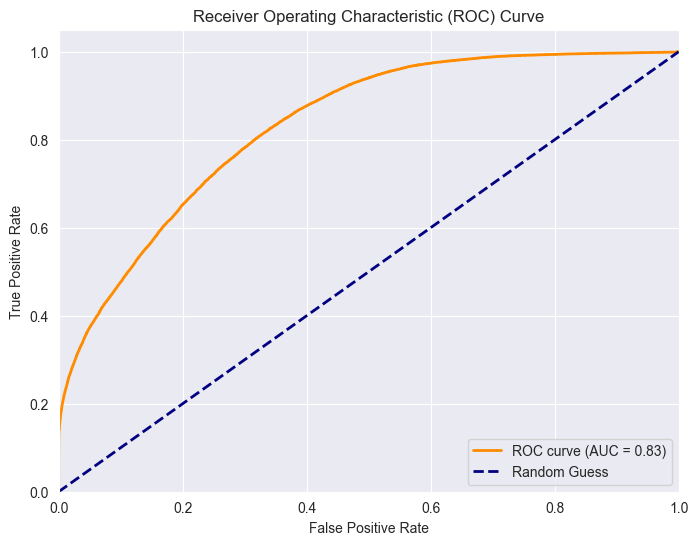

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86     75189
         1.0       0.64      0.48      0.55     28487

    accuracy                           0.78    103676
   macro avg       0.73      0.69      0.70    103676
weighted avg       0.77      0.78      0.77    103676



In [19]:
coefficients = lr_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

In [20]:
top_20_features = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False).head(20)

In [21]:
print(top_20_features[['Feature', 'Coefficient', 'Absolute_Coefficient']])

         Feature  Coefficient  Absolute_Coefficient
12    day_sunset    -2.925400              2.925400
11   day_sunrise    -2.508274              2.508274
83            45    -1.646343              1.646343
85            47    -1.634898              1.634898
956          918     1.530994              1.530994
877          839     1.496167              1.496167
876          838     1.388980              1.388980
987          949     1.325199              1.325199
148          110     1.262944              1.262944
493          455     1.244760              1.244760
746          708    -1.228420              1.228420
393          355    -1.205935              1.205935
981          943    -1.079213              1.079213
234          196    -1.072563              1.072563
878          840     1.050401              1.050401
149          111     1.043392              1.043392
973          935     1.035721              1.035721
419          381     1.028646              1.028646
81          